In [1]:
import numpy as np
import matplotlib.pyplot as plt
import chiLife as xl
from scipy.spatial.transform import Rotation
from scipy.optimize import minimize

C:\Program Files\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def phitodepth(phi):
    A, B, C, D = 3.8, 0.079, 10.2, 1.1
    return (np.arctanh((phi - D) / A) / B) + C

In [3]:
bci = xl.fetch('1bci').select_atoms('protein')
sites, phis = np.loadtxt('MembraneDepthParameters.txt').T
sites, phis

(array([ 31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  41.,  63.,
         64.,  65.,  66.,  67.,  68.,  94.,  95.,  96.,  97.,  98.,  99.,
        100., 101.]),
 array([-1.5 , -0.1 , -1.  ,  0.4 ,  1.9 ,  1.5 , -0.3 ,  0.94,  2.4 ,
        -1.5 , -1.4 , -1.2 , -0.8 , -1.6 , -1.4 , -1.8 , -0.5 ,  0.2 ,
         0.8 ,  1.  ,  0.3 , -0.5 , -1.1 , -1.7 ]))

In [4]:
for iterat in range(10):
    label_list = []
    spin_centroids = []
    depths = phitodepth(phis)

    for site, depth in zip(sites, depths):
        SL = xl.SpinLabel('R1A', int(site), protein=bci, sample=1000)
        spin_centroids.append(SL.spin_centroid)
        label_list.append(SL)

    spin_centroids = np.array(spin_centroids)
    spin_cen = np.mean(spin_centroids, axis=0)
    spin_at_ori = spin_centroids - spin_cen

    def objective(par):
        x, y, z, zdepth = par
        R = Rotation.from_euler('xyz', [x, y, z])

        M = R.as_matrix()

        new_spin_coords = spin_at_ori@M + np.array([0, 0, zdepth])
        resid = new_spin_coords[:, 2] - depths

        return resid @ resid


    
    fit = minimize(objective, x0=[0, 0, 0, 0], bounds=[[-180, 180], [-180, 180], [-180, 180], [-100, 100]])
    print(fit.fun)
    R = Rotation.from_euler('xyz', fit.x[:3]).as_matrix()

    bci.atoms.positions = (bci.atoms.positions - spin_cen) @ R + np.array([0, 0, fit.x[-1]])

    spin_centroids = []
    for i, SL in enumerate(label_list):
        SL.coords = (SL.coords - spin_cen) @ R + np.array([0, 0, fit.x[-1]])
        spin_centroids.append(SL.spin_centroid)

    bci.atoms.write(f'translated{iterat}.pdb')
    xl.save(*label_list, f'translated{iterat}.pdb', KDE=False)

  warnings.warn("Unit cell dimensions not found. "



225.14927469170482
translated0.pdb translated0_many_labels.pdb
233.42425699991753
translated1.pdb translated1_many_labels.pdb
228.23621285557198
translated2.pdb translated2_many_labels.pdb
243.09113465248078
translated3.pdb translated3_many_labels.pdb
229.75447715323915
translated4.pdb translated4_many_labels.pdb
201.38527249358205
translated5.pdb translated5_many_labels.pdb
232.27278384090374
translated6.pdb translated6_many_labels.pdb
229.695222020331
translated7.pdb translated7_many_labels.pdb
235.680705279787
translated8.pdb translated8_many_labels.pdb
217.86819262655717
translated9.pdb translated9_many_labels.pdb


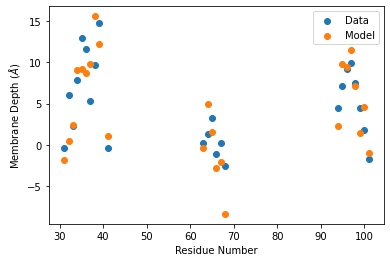

In [32]:
import matplotlib.pyplot as plt
plt.scatter(sites, depths, label='Data')
plt.scatter(sites, spin_centroids[:,2], label='Model')
plt.ylabel('Membrane Depth ($\AA$)')
plt.xlabel('Residue Number')
plt.legend()
plt.show()
